In [25]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy.signal as scisig
import scipy.optimize as optimize
from scipy.fft import fft 
import numpy.fft as npfft
url='https://raw.githubusercontent.com/hockijo/PNMR-Data/main'

In [26]:
def osscPlot(file, directory=(url+"/osscimports/data")):
    data = pd.read_csv(directory+file)
    data_clean=data.drop(labels=0).astype(float)
    
    fig,ax=plt.subplots()
    for column in data_clean.columns[1:]:
        ax.plot(data_clean["x-axis"], data_clean[column],label=column)
    ax.legend()
    ax.set_xlabel("Time(s)")
    ax.set_ylabel("Voltage(V)")
    plt.show(fig)
    #plt.savefig(directory+file[:-4]+".png") commented all saves for this upload

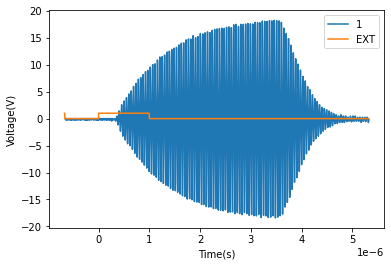

In [27]:
i=0
osscPlot(f"/scope_{i}.csv")    

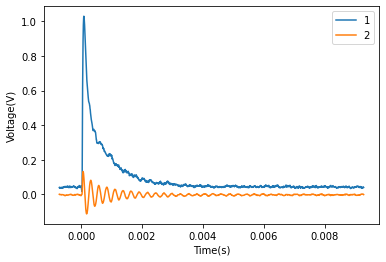

In [28]:
i=1
osscPlot(f"/scope_{i}.csv")    

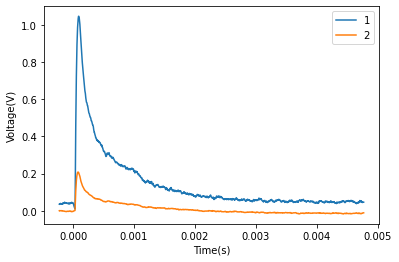

In [29]:
i=2
osscPlot(f"/scope_{i}.csv")    

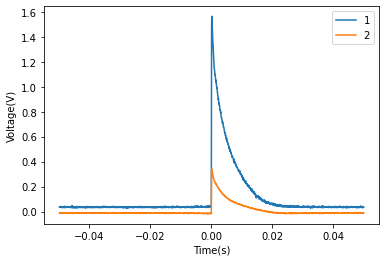

In [30]:
i=3
osscPlot(f"/scope_{i}.csv")    

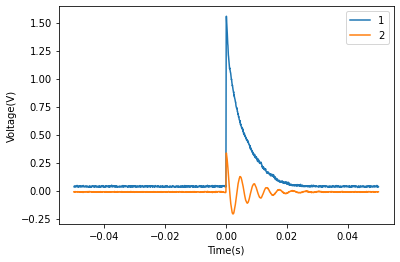

In [31]:
i=4
osscPlot(f"/scope_{i}.csv")    

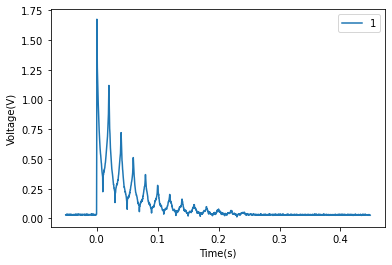

In [35]:
i=134
osscPlot(f"/scope_{i}.csv",directory=url+'/T2/data')   

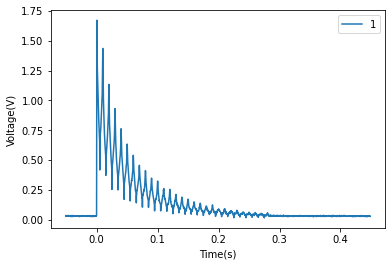

In [36]:
i=135
osscPlot(f"/scope_{i}.csv",directory=url+'/T2/data')   

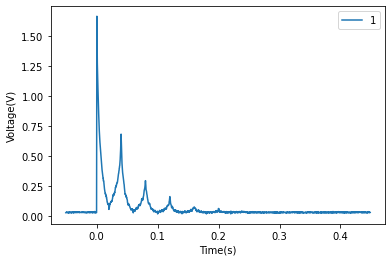

In [37]:
i=136
osscPlot(f"/scope_{i}.csv",directory=url+'/T2/data')   

In [38]:
def model(x, M, T, c):
    return M*np.exp(-x*T)+c

def getexp_fits(scope_number):
    directory=url+"/T2"
    file=f"/scope_{scope_number}.csv"

    data = pd.read_csv(directory+file)
    data_clean=data.drop(labels=0).astype(float)

    peak_indexes=scisig.find_peaks(data_clean['1'].values, prominence=0.05)[0]
    dip_indexes=scisig.find_peaks(-data_clean['1'].values, prominence=0.025)[0]
    peak_times=data_clean.at[data_clean['1'].idxmax(),'x-axis']

    peak_indexes=peak_indexes[:len(dip_indexes)]

    decay_fit_parameters={}
    decay_fit={}
    decay_x_axis={}

    for i in range(len(peak_indexes)):
        decay_data=data_clean[peak_indexes[i]-1:dip_indexes[i]]

        try:
            filitered_decay_dict={'x-axis':decay_data['x-axis'],'1':scisig.savgol_filter(decay_data['1'],10,4)}
            filtered_decay=pd.DataFrame(data=filitered_decay_dict)

            parameters,cv = optimize.curve_fit(model, filtered_decay['x-axis'], filtered_decay['1'],method='trf')
        except: continue
        M,T,c =  parameters[0],parameters[1],parameters[2]
        decay_fit_parameters[f'{i}'] = (M,T,c)
        decay_fit[f'{i}'] = model(filtered_decay['x-axis'],M,T,c)
        decay_x_axis[f'{i}'] = filtered_decay['x-axis']

    fig,ax=plt.subplots()
    plt.plot(data_clean["x-axis"], data_clean.loc[:, data_clean.columns!='x-axis'],'y--',label="Data")
    for key in decay_fit:
        #plt.plot(decay_x_axis[key], decay_fit[key])
        ax.plot(decay_x_axis[key], decay_fit[key],label=f'{key} decay fit')
        plt.text(0.1,1-0.1*float(key),f'The time const for the {key} decay is {1/decay_fit_parameters[key][1]*10**3:.3f}ms\n')
    ax.legend()
    ax.set_xlabel("Time(s)")
    ax.set_ylabel("Voltage(V)")
    plt.show(fig)
    #plt.savefig(directory+file[:-4]+".png")

    plt.show()

In [39]:
def getExpDecay(scope_number):
    directory=url+"/T2"
    file=f"/data/scope_{scope_number}.csv"

    data = pd.read_csv(directory+file)
    data_clean=data.drop(labels=0).astype(float)

    peak_indexes=scisig.find_peaks(data_clean['1'].values, prominence=0.05)[0] #prominence could be decreased to examine tail peaks,
    #however somtimes it leads to finding false peaks

    peaks=data_clean.iloc[peak_indexes].reset_index(drop=True)

    parameters,cv = optimize.curve_fit(lambda t,M,T,c:M*np.exp(t*T)+c, peaks['x-axis'], peaks['1'],p0=(1.6,-20,0.08))
    M,T,c = parameters[0],parameters[1], parameters[2]
    decay_fit = M*np.exp(data_clean['x-axis'][peak_indexes[0]:]*T)+c

    fig,ax =plt.subplots()
    ax.plot(data_clean['x-axis'],data_clean['1'],label='Data')
    ax.plot(peaks['x-axis'],peaks['1'],'.r',label='Peaks')
    ax.plot(data_clean['x-axis'][peak_indexes[0]:], decay_fit,'--',label='Fit')
    ax.legend()
    plt.text(0.35,1.25,f"T2={-1/T*10**3:.3f}ms")
    ax.set_xlabel("Time(s)")
    ax.set_ylabel("Voltage(V)")

    #plt.savefig(directory+file[:-4]+"T2.png")
    plt.show()
    
    lines=[f'M={M}',f'T={T}',f'c={c}',f'Model is M*exp(T*t)+c']
    #with open(directory+file[:-4]+"_parameters.csv",'w') as f:
        #for line in lines:
            #f.write(line+"\n")

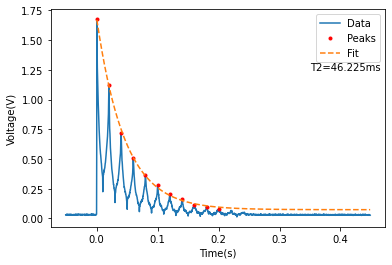

In [40]:
getExpDecay(134)

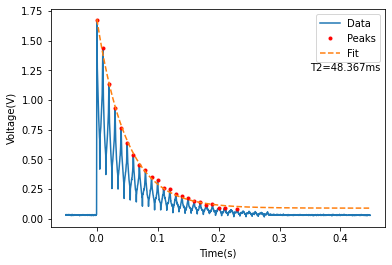

In [41]:
getExpDecay(135)

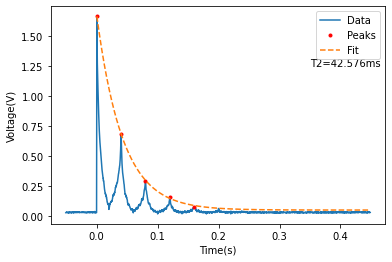

In [42]:
getExpDecay(136)

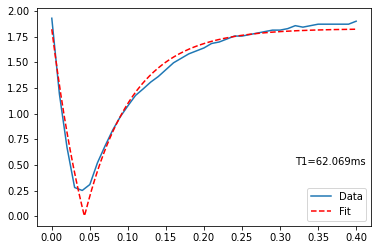

In [46]:
directory=url+"/T1-decay%20data"

peak_times=np.linspace(0.0001,0.4001,41) #this is tau
peak_volts=[]
#a for loop for opening the csv files, pulling the max value and appending that to a list. This could be improved as it sometimes reads Pulse A when
#the value for pulse B is lower than it.
for i in range(5,46):
    file= f"/data/scope_{i}.csv"
    data = pd.read_csv(directory+file)
    data_clean=data.drop(labels=0).astype(float)
    peak_index=data_clean["1"].idxmax()
    #peak_times.append(data_clean["x-axis"][peak_index])
    peak_volts.append(data_clean["1"][peak_index])
    #print(i,data_clean["1"][peak_index])

#there is an outlier with data point 28, I beleive the ossciloscope did not pick up the signal from pulse B, 
#instead my code would be taking a second from the following period 180d pulse as the max. Hence I am excluding this data point.


#plt.scatter(peak_times,peak_volts)

dDict={"Time": peak_times,"Volts": peak_volts} #could imporve efficiency by writing drictly to dict
peaks=pd.DataFrame.from_dict(dDict)
peaks_clean=peaks.drop(28)

minimum_index=peaks_clean['Volts'].idxmin()
rising=peaks_clean.iloc[minimum_index+1:] #as there is a slight ramp up when rising, i avoid that by +1 index to purely get an expontial curve to fit

parameters, cv = optimize.curve_fit(lambda t,a,b:np.abs(a*(1-2*np.exp(b*t))), peaks_clean['Time'], peaks_clean['Volts'],p0=(1.8,-15)) #cv contains info like std error
a,b = parameters[0],parameters[1]#,parameters[2]
rise_fit = np.abs(a*(1-2*np.exp(b*np.linspace(peaks_clean['Time'][0],peaks_clean['Time'].iloc[-1],300))))

#print(f"T1={-1/b*10**3:.3f}ms")

fig,ax=plt.subplots()
ax.plot(peaks_clean['Time'],peaks_clean['Volts'],label='Data')
ax.plot(np.linspace(peaks_clean['Time'][0],peaks_clean['Time'].iloc[-1],300),rise_fit,'--r',label='Fit')
ax.legend()
plt.text(0.32,0.5,f"T1={-1/b*10**3:.3f}ms")

plt.show()
#plt.savefig(directory+"/graphT1.png")

lines=[f'a={a}',f'b={b}',f'Model is ABS(a*(1-2))']#,f'c={c}'
#with open(directory+"/T1_parameters-edited.csv",'w') as f:
    #for line in lines:
        ##f.write(line+"\n")

In [47]:
np.abs(a*(1-2*np.exp(b*0)))

1.8290500713557627

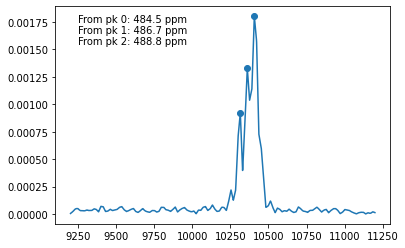

In [48]:
directory=url+"/Spectrometer"
file="/scope_1.csv"

data = pd.read_csv(directory+file)
data_trace=data.iloc[0:2001].drop(labels=0).astype(float)
data_fft=data.iloc[2002:].drop(labels=2002).astype(float)

fft_peak_indexes=scisig.find_peaks(data_fft['1'].values, prominence=0.0001)[0]
peak_lst=data_fft['x-axis'].iloc[fft_peak_indexes].values
v_peak_lst=data_fft['1'].iloc[fft_peak_indexes].values

fig,ax=plt.subplots()
for i in range(0,len(fft_peak_indexes)):
    plt.text(9250,0.00175-0.0001*i,f'From pk {i}: {((peak_lst[i])/(21.29*10**6))*10**6:.1f} ppm')#trouble caluclating this ppm
ax.scatter(data_fft['x-axis'].iloc[fft_peak_indexes],data_fft['1'].iloc[fft_peak_indexes],marker='o')
ax.plot(data_fft['x-axis'],data_fft['1'])

plt.show()

#print(f'The frequency differences are {}')

In [ ]:
#this fft is not working currently
directory=f"{os.getcwd()}/Spectrometer"
file=f"/scope_1.csv"

data = pd.read_csv(directory+file)
data_trace=data.iloc[0:2001].drop(labels=0).astype(float)
data_fft=data.iloc[2002:].drop(labels=2002).astype(float)

X = fft(npfft.fft(data_trace[['2']]))
N = len(X)
n = np.arange(N)
sr = 1 / (60*60)
T = N/sr
freq = n/T 

# Get the one-sided specturm
n_oneside = N//2
# get the one side frequency
f_oneside = freq[:n_oneside]

plt.figure(figsize = (12, 6))
plt.plot(f_oneside, np.abs(X[:n_oneside]), 'b')
plt.xlabel('Freq (Hz)')
plt.ylabel('FFT Amplitude |X(freq)|')
plt.show()